# TODO: Performance wasn't very good. Predict week by week and calc moving average for next week!
Steps: 
- a) Split up test set by week
- b) Give week 1 the same EWMA as the last week in the training set.
- c) Predict week 1
- d) Calc EWMA for following week
- e) Predict following week
- f) Repeat d & e until all predictions are made.

# Import libraries

In [122]:
import os
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.2.0-posix-seh-rt_v5-rev1\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import gc # Note: this is a garbage collector
%matplotlib inline

import warnings
warnings.filterwarnings('ignore') 

# Bring in data

In [123]:
PATH = r"..\Raw_Data"

In [124]:
data = {
#    'airRes':    pd.read_csv(PATH + r"\air_reserve.csv"),
    'airStore':  pd.read_csv(PATH + r"\air_store_info.csv"),
    'airVisit':  pd.read_csv(PATH + r"\air_visit_data.csv"),
    'date':      pd.read_csv(PATH + r"\date_info.csv"),
#    'hpgRes':    pd.read_csv(PATH + r"\hpg_reserve.csv"),
#    'hpgStore':  pd.read_csv(PATH + r"\hpg_store_info.csv"),
    'sampleSub': pd.read_csv(PATH + r"\sample_submission.csv"),
    'storeIDs':  pd.read_csv(PATH + r"\store_id_relation.csv")    
}

In [125]:
#data['airStore'].tail(50)

In [126]:
#data['airVisit'].head(15)
#data['airRes'].reserve_datetime.max()

# Preprocess data

In [127]:
data['date']['visit_date'] = pd.to_datetime(data['date']['calendar_date'])
data['date'].drop('calendar_date', axis = 1 , inplace=True)

In [128]:
data['airVisit']['visit_date'] = pd.to_datetime(data['airVisit']['visit_date'])
data['airVisit']['dow'] = data['airVisit']['visit_date'].dt.dayofweek
data['airVisit']['year'] = data['airVisit']['visit_date'].dt.year
data['airVisit']['month'] = data['airVisit']['visit_date'].dt.month

## Add EWMA of visits as feature

In [129]:
# Function to calculate ewm (note, found this on the discussion forum):
def calc_shifted_ewm(series, alpha, adjust = True):
    return series.shift().ewm(alpha = alpha, adjust = adjust).mean()

In [130]:
# Step below adds the ewm by day of week. Right now I'm returning a separate series so I can look at what each step does if I want to
tmp = data['airVisit'].groupby(['air_store_id','dow']).apply(lambda x: calc_shifted_ewm(x['visitors'], 0.1)) 
# This step backfills the 1st week's dow for each restaurant, otherwise it would be NaN since it's a 1-period ewma
tmp = tmp.fillna(method='bfill')
# The groupby function returns a multiIndex Series. I only need the 3rd level (original df index) to add column to original df
tmp.index = tmp.index.get_level_values(2)
# Sort index before adding back to original df
tmp = tmp.sort_index()

In [131]:
data['airVisit']['ewma'] = tmp

## Add 'days since last' and 'days until next' holiday

In [132]:
# Create a 'days since holiday' feature
daysSinceList = []
daysSinceHol = 0 # initialize daysSince counter
for row in data['date']['holiday_flg']:
    if row == 1:
        daysSinceHol = 0
        daysSinceList.append(daysSinceHol)
    else:
        daysSinceHol += 1
        daysSinceList.append(daysSinceHol)
data['date']['days_since_holiday'] = daysSinceList

In [133]:
# Create a 'days UNTIL next holiday' feature
holidayList = list(data['date']['holiday_flg'])
daysUntilHolList = np.zeros(len(holidayList),dtype=np.int)
daysUntilHol = 0 # initialize daysUntilHol counter
for i in range(len(holidayList)-1,0,-1):
    if holidayList[i] == 1:
        daysUntilHol = 0
        daysUntilHolList[i] = daysUntilHol
    else:
        daysUntilHol += 1
        daysUntilHolList[i] = daysUntilHol        
data['date']['days_until_holiday'] = daysUntilHolList

## Merge air_visits with date dframe to get holiday info

In [134]:
colsToMerge = ['holiday_flg','visit_date','days_until_holiday','days_since_holiday']
df_train = pd.merge(data['airVisit'], data['date'][colsToMerge], how = 'left', on = 'visit_date')

In [135]:
#df_train.head()

## Filter only the stores that must be predicted

In [136]:
df_test = data['sampleSub']

df_test['visit_date'] = df_test['id'].map(lambda x: str(x).split('_')[2])
df_test['air_store_id'] = df_test['id'].map(lambda x: '_'.join(str(x).split('_')[:2]))
df_test['visit_date'] = pd.to_datetime(df_test['visit_date'])
df_test['dow'] = df_test['visit_date'].dt.dayofweek
df_test['year'] = df_test['visit_date'].dt.year
df_test['month'] = df_test['visit_date'].dt.month

unique_stores = df_test['air_store_id'].unique()
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)
#stores.head()

## Merge df_test with date dframe to get holiday info

In [137]:
df_test = pd.merge(df_test, data['date'][colsToMerge], how = 'left', on = 'visit_date')

In [138]:
stores = pd.merge(stores, data['airStore'], how='left', on=['air_store_id'])
#stores.head()

In [139]:
# Encode categorical string variables 
lbl = LabelEncoder()
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

In [141]:
#stores.head()

## Add genre and area to train and test data

In [142]:
df_train = pd.merge(df_train, stores, how = 'left', on = ['air_store_id','dow'])

### Add visitor statistics as features

In [143]:
tmp = df_train.groupby(['air_store_id','dow']).agg({'visitors' : [np.min,np.mean,np.median,np.max,np.size]}).reset_index()
tmp.columns = ['air_store_id', 'dow', 'min_visitors', 'mean_visitors', 'median_visitors','max_visitors','count_observations']
#stores = pd.merge(df_train, tmp, how='left', on=['air_store_id','dow'])
df_train = pd.merge(df_train, tmp, how='left', on=['air_store_id','dow'])
#print(df_train.columns)
#print(df_train.head())
#df_train.isnull().any()
#print(stores.columns)

In [144]:
#df_test.isnull().any()

In [145]:
df_test = pd.merge(df_test, stores, how = 'left', on = ['air_store_id','dow'])

In [146]:
df_test = pd.merge(df_test, tmp, how='left', on=['air_store_id','dow'])
#df_test.head()

Note: For XGB, didn't fillna (1/28/2018)
Other algorithms need fillna. TODO: 1) investigate why there are NaN on train set. 2) Check if XGBoost gets better score with fillna

In [159]:
df_train = df_train.fillna(-1)
df_test = df_test.fillna(-1)

In [160]:
train = df_train
test = df_test
col = [c for c in train if c not in ['id', 'air_store_id','visit_date','visitors']]
#test.head()

# Initialize XGBoost
Note - code based on:
https://www.kaggle.com/jmbull/no-xgb-starter-here-s-one-lb-507

In [161]:
# XGB starter template borrowed from @anokas
# https://www.kaggle.com/anokas/simple-xgboost-starter-0-0655

print('Binding to float32')

for c, dtype in zip(df_train.columns, train.dtypes):
    if dtype == np.float64:
        train[c] = train[c].astype(np.float32)
        
for c, dtype in zip(df_test.columns, test.dtypes):
    if dtype == np.float64:
        test[c] = test[c].astype(np.float32)

Binding to float32


In [162]:
x_train = train.drop(['air_store_id','visit_date','visitors'], axis=1)
y_train = np.log1p(train['visitors'].values)

# Get Column order for x_test df
colOrder = x_train.columns

In [163]:
print(x_train.shape, y_train.shape)
#print(colOrder)

(252108, 16) (252108,)


In [164]:
#train.head()

In [165]:
# Create training / validation split
split = 200000
x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]

print('Building DMatrix...')

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

#del x_train, x_valid; gc.collect()

Building DMatrix...


In [154]:
print('Training ...')

params = {}
params['objective'] = 'reg:linear'
params['eval_metric'] = 'rmse'
params['eta'] = 0.04
params['max_depth'] = 7
params['silent'] = 1

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
clf = xgb.train(params, d_train, 10000, watchlist, early_stopping_rounds=100, verbose_eval=25)

del d_train, d_valid

Training ...
[0]	train-rmse:2.35531	valid-rmse:2.31585
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[25]	train-rmse:0.973017	valid-rmse:0.95965
[50]	train-rmse:0.585418	valid-rmse:0.578816
[75]	train-rmse:0.509776	valid-rmse:0.50554
[100]	train-rmse:0.49554	valid-rmse:0.493567
[125]	train-rmse:0.490849	valid-rmse:0.491035
[150]	train-rmse:0.4875	valid-rmse:0.489895
[175]	train-rmse:0.485201	valid-rmse:0.489546
[200]	train-rmse:0.483488	valid-rmse:0.489522
[225]	train-rmse:0.481922	valid-rmse:0.489461
[250]	train-rmse:0.480362	valid-rmse:0.489618
[275]	train-rmse:0.479144	valid-rmse:0.48961
[300]	train-rmse:0.477884	valid-rmse:0.489609
Stopping. Best iteration:
[220]	train-rmse:0.482217	valid-rmse:0.489398



['dow', 'year', 'month', 'ewma', 'holiday_flg', 'days_until_holiday', 'days_since_holiday', 'air_genre_name', 'air_area_name', 'latitude', 'longitude', 'min_visitors', 'mean_visitors', 'median_visitors', 'max_visitors', 'count_observations']


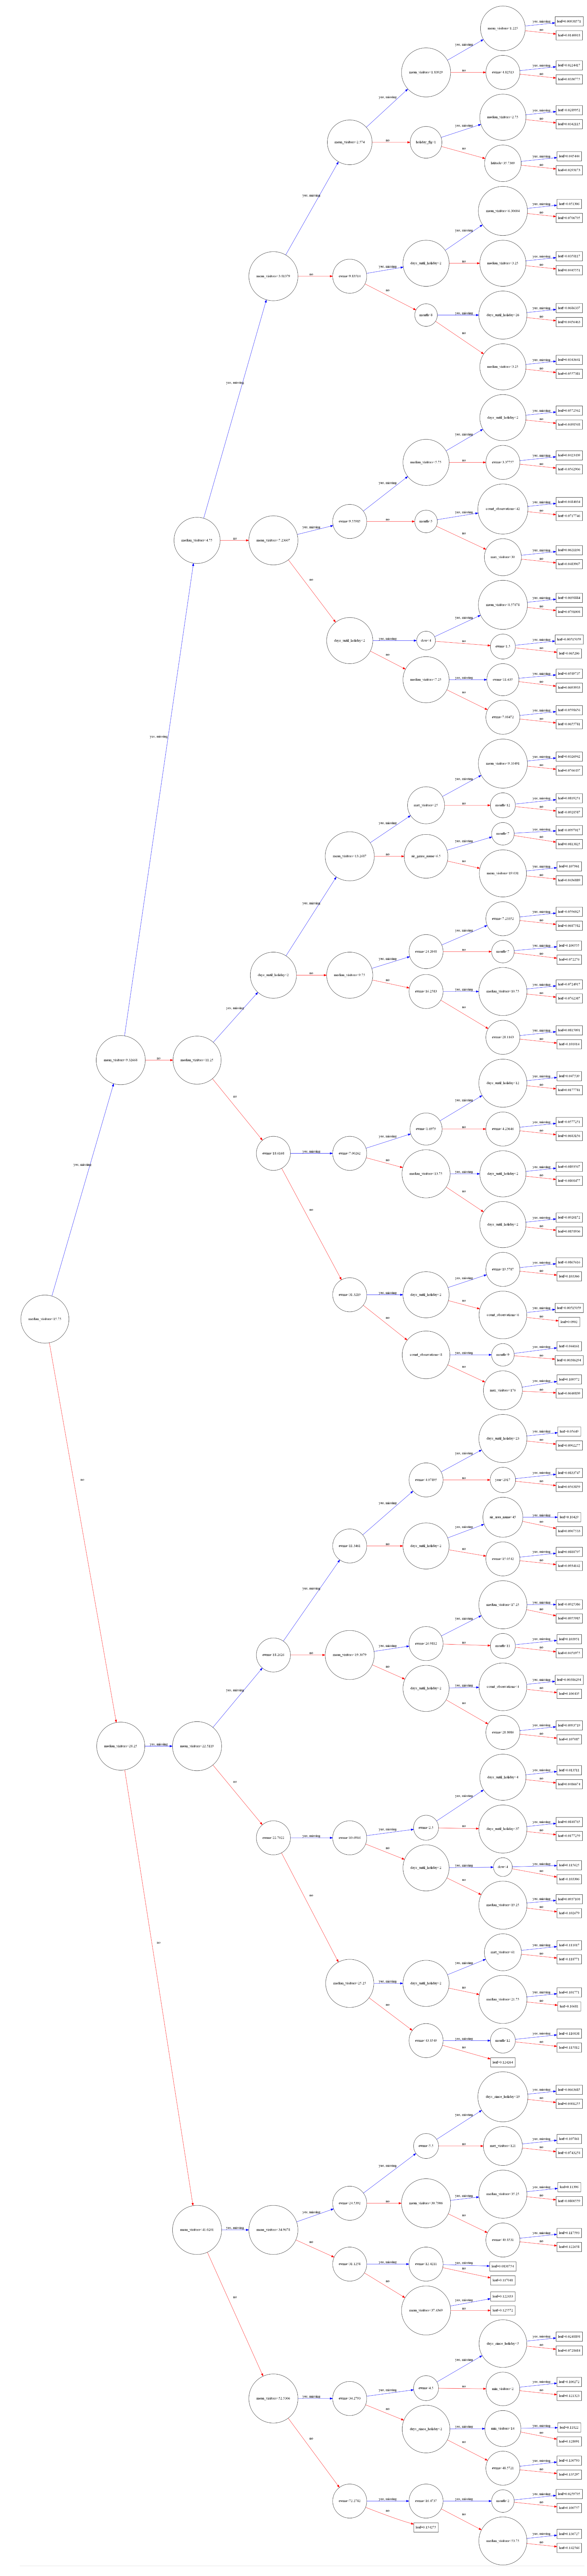

In [93]:
print(clf.feature_names)
xgb.plot_tree(clf, num_trees=0,rankdir='LR')
#plt.show()
#plt.savefig('samplePlot.png')
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')

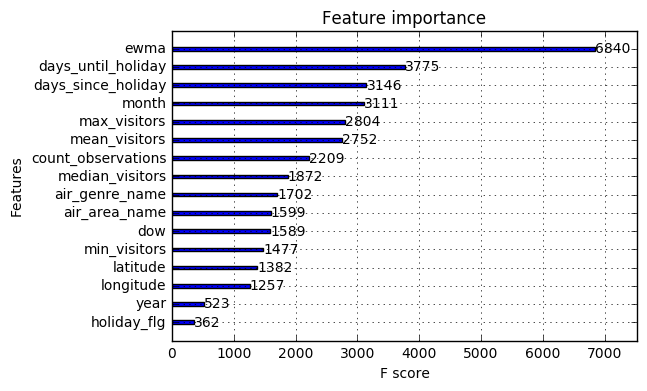

In [186]:
xgb.plot_importance(clf)

### TODO: Use ewma feature in test set
1. Assign ewma to 1st week of test set using last week of training
2. Predict
3. Calc ewma for 2nd week of test set
4. predict again

In [35]:
# Get dataframe for last week of training set and only use store
x_train_lastWk = train[['air_store_id','visit_date','dow','ewma']]
x_train_lastWk = x_train_lastWk[x_train_lastWk['visit_date'] > '2017-04-15']
#print(x_train_LastWk.head(2))
#x_train_lastWk.head(10)
#print("total entries: " + str(len(x_train_LastWk)))
#print("total stores: " + str(len(x_train_LastWk['air_store_id'].unique())))

In [36]:
#x_train_LastWk['dow'] = x_train_LastWk['dow'].astype(str)
#x_train_LastWk['store_with_dow']=x_train_LastWk[['air_store_id','dow']].apply(lambda x: '_'.join(x),axis=1)
#x_train_LastWk.head()

In [37]:
#x_train_LastWk.groupby('dow')['air_store_id'].count()

In [38]:
# Split test by weeks [note that weeks start on day 6 (Sunday) rather than day 0 (Monday)]
#test['ewma'] = np.random.randint(1, 20, x_test.shape[0])
test.index = test['visit_date']
#test.head()
testWk1 = test['2017-04-23':'2017-04-29']
testWk2 = test['2017-04-30':'2017-05-06']
testWk3 = test['2017-05-07':'2017-05-13']
testWk4 = test['2017-05-14':'2017-05-20']
testWk5 = test['2017-05-21':'2017-05-27']
testWk6 = test['2017-05-28':'2017-06-01']
#testWk6.head(2)

In [39]:
testWk1_pred = pd.merge(testWk1, x_train_lastWk.drop('visit_date',axis=1),how='left',on=['air_store_id','dow'])

In [40]:
testWk1_pred['ewma'] = testWk1_pred['ewma'].fillna(value=0)
#testWk1_pred.head(10)

Command to put columns in the right order for the XGBoost prediction

In [41]:
# NOTE: USE COLUMN LIST BELOW IF NOT INCLUDING VISITOR STATISTICS IN TRAINING SET

#columnsForTest_df = ['dow', 'year', 'month', 'ewma', 'holiday_flg', 'days_until_holiday',
#       'days_since_holiday', 'air_genre_name', 'air_area_name', 'latitude',
#       'longitude']

# NOTE: USE COLUMN LIST BELOW IF INCLUDING VISITOR STATISTICS IN TRAINING SET
columnsForTest_df = ['dow', 'year', 'month', 'ewma', 'holiday_flg', 'days_until_holiday', 'days_since_holiday',
                     'air_genre_name', 'air_area_name', 'latitude', 'longitude', 'min_visitors', 'mean_visitors',
                     'median_visitors', 'max_visitors', 'count_observations']

In [42]:
x_testWk1_pred = testWk1_pred.drop(['id','air_store_id','visit_date','visitors'],axis=1)
x_testWk1_pred = x_testWk1_pred[columnsForTest_df]

In [43]:
d_test = xgb.DMatrix(x_testWk1_pred)
#del x_test; gc.collect()

In [44]:
print('Predicting on test ...')
p_test = clf.predict(d_test)
del d_test; gc.collect()

Predicting on test ...


36

In [45]:
np.expm1(p_test)

array([  1.7477169 ,  19.51970482,  24.59268951, ...,   3.97547293,
         5.10497904,   7.4379673 ], dtype=float32)

In [46]:
testWk1_pred['visitors'] = np.expm1(p_test)
testWk1_pred[['id','visitors']].to_csv('xgb_submission_Wk1.csv', index=False, float_format='%.3f')

### With test set Week 1 predicted, update ewma and assign to week 2

In [47]:
train_testWk1_concat = testWk1_pred[train.columns]
train_testWk1_concat = pd.concat([train, train_testWk1_concat])
train_testWk1_concat = train_testWk1_concat.reset_index()
tmp = train_testWk1_concat.groupby(['air_store_id','dow']).apply(lambda x: calc_shifted_ewm(x['visitors'],0.1))
tmp = tmp.fillna(method='bfill')
tmp.index = tmp.index.get_level_values(2)
tmp = tmp.sort_index()

In [48]:
train_testWk1_concat['ewma'] = tmp

In [49]:
tmp = train_testWk1_concat[train_testWk1_concat['visit_date'] > testWk2.visit_date.min() - pd.to_timedelta(1, unit='d')]
tmp = tmp[['air_store_id','visit_date','dow','ewma']]
testWk2_pred = pd.merge(testWk2, tmp.drop('visit_date',axis=1),how='left',on=['air_store_id','dow'])
testWk2_pred['ewma'] = testWk2_pred['ewma'].fillna(value=0)

In [50]:
x_testWk2_pred = testWk2_pred.drop(['id','air_store_id','visit_date','visitors'],axis=1)
x_testWk2_pred = x_testWk2_pred[columnsForTest_df]
x_testWk2_pred.columns

Index(['dow', 'year', 'month', 'ewma', 'holiday_flg', 'days_until_holiday',
       'days_since_holiday', 'air_genre_name', 'air_area_name', 'latitude',
       'longitude', 'min_visitors', 'mean_visitors', 'median_visitors',
       'max_visitors', 'count_observations'],
      dtype='object')

In [51]:
d_test = xgb.DMatrix(x_testWk2_pred)
#del x_test; gc.collect()

In [52]:
print('Predictin on test ...')
p_test = clf.predict(d_test)
del d_test; gc.collect()

Predictin on test ...


104

In [53]:
testWk2_pred['visitors'] = np.expm1(p_test)
testWk2_pred[['id','visitors']].to_csv('xgb_submission_Wk2.csv',index=False,float_format='%.3f')

### With test set Week 2 predicted, update ewma and assign to week 3

In [54]:
#train_testWk1_concat.tail(2)

In [55]:
train_testWk2_concat = testWk2_pred[train.columns]
train_testWk2_concat = pd.concat([train_testWk1_concat, train_testWk2_concat])
train_testWk2_concat = train_testWk2_concat.reset_index()
tmp = train_testWk2_concat.groupby(['air_store_id','dow']).apply(lambda x: calc_shifted_ewm(x['visitors'],0.1))
tmp = tmp.fillna(method='bfill')
tmp.index = tmp.index.get_level_values(2)
tmp = tmp.sort_index()

In [56]:
train_testWk2_concat['ewma'] = tmp

In [57]:
tmp = train_testWk2_concat[train_testWk2_concat['visit_date'] > testWk3.visit_date.min() - pd.to_timedelta(1, unit='d')]
tmp = tmp[['air_store_id','visit_date','dow','ewma']]
testWk3_pred = pd.merge(testWk3, tmp.drop('visit_date',axis=1),how='left',on=['air_store_id','dow'])
testWk3_pred['ewma'] = testWk3_pred['ewma'].fillna(value=0)

In [58]:
x_testWk3_pred = testWk3_pred.drop(['id','air_store_id','visit_date','visitors'],axis=1)
x_testWk3_pred = x_testWk3_pred[columnsForTest_df]

In [59]:
d_test = xgb.DMatrix(x_testWk3_pred)
#del x_test; gc.collect()

In [60]:
print('Predictin on test ...')
p_test = clf.predict(d_test)
del d_test; gc.collect()

Predictin on test ...


101

In [61]:
testWk3_pred['visitors'] = np.expm1(p_test)
testWk3_pred[['id','visitors']].to_csv('xgb_submission_Wk3.csv',index=False,float_format='%.3f')

### With test set Week 3 predicted, update ewma and assign to week 4

In [62]:
train_testWk3_concat = pd.concat([train_testWk2_concat[train.columns], testWk3_pred[train.columns]])
train_testWk3_concat = train_testWk3_concat.reset_index()
tmp = train_testWk3_concat.groupby(['air_store_id','dow']).apply(lambda x: calc_shifted_ewm(x['visitors'],0.1))
tmp = tmp.fillna(method='bfill')
tmp.index = tmp.index.get_level_values(2)
tmp = tmp.sort_index()

In [63]:
train_testWk3_concat['ewma'] = tmp

In [64]:
tmp = train_testWk3_concat[train_testWk3_concat['visit_date'] > testWk4.visit_date.min() - pd.to_timedelta(1, unit='d')]
tmp = tmp[['air_store_id','visit_date','dow','ewma']]
testWk4_pred = pd.merge(testWk4, tmp.drop('visit_date',axis=1),how='left',on=['air_store_id','dow'])
testWk4_pred['ewma'] = testWk4_pred['ewma'].fillna(value=0)

In [65]:
x_testWk4_pred = testWk4_pred.drop(['id','air_store_id','visit_date','visitors'],axis=1)
x_testWk4_pred = x_testWk4_pred[columnsForTest_df]

In [66]:
d_test = xgb.DMatrix(x_testWk4_pred)
#del x_test; gc.collect()

In [67]:
print('Predictin on test ...')
p_test = clf.predict(d_test)
del d_test; gc.collect()

Predictin on test ...


101

In [68]:
testWk4_pred['visitors'] = np.expm1(p_test)
testWk4_pred[['id','visitors']].to_csv('xgb_submission_Wk4.csv',index=False,float_format='%.3f')

### With test set Week 4 predicted, update ewma and assign to week 5

In [69]:
train_testWk4_concat = pd.concat([train_testWk3_concat[train.columns], testWk4_pred[train.columns]])
train_testWk4_concat = train_testWk4_concat.reset_index()
tmp = train_testWk4_concat.groupby(['air_store_id','dow']).apply(lambda x: calc_shifted_ewm(x['visitors'],0.1))
tmp = tmp.fillna(method='bfill')
tmp.index = tmp.index.get_level_values(2)
tmp = tmp.sort_index()

In [70]:
train_testWk4_concat['ewma'] = tmp

In [71]:
tmp = train_testWk4_concat[train_testWk4_concat['visit_date'] > testWk5.visit_date.min() - pd.to_timedelta(1, unit='d')]
tmp = tmp[['air_store_id','visit_date','dow','ewma']]
testWk5_pred = pd.merge(testWk5, tmp.drop('visit_date',axis=1),how='left',on=['air_store_id','dow'])
testWk5_pred['ewma'] = testWk5_pred['ewma'].fillna(value=0)

In [72]:
x_testWk5_pred = testWk5_pred.drop(['id','air_store_id','visit_date','visitors'],axis=1)
x_testWk5_pred = x_testWk5_pred[columnsForTest_df]

In [73]:
d_test = xgb.DMatrix(x_testWk5_pred)
#del x_test; gc.collect()

In [74]:
print('Predictin on test ...')
p_test = clf.predict(d_test)
del d_test; gc.collect()

Predictin on test ...


101

In [75]:
testWk5_pred['visitors'] = np.expm1(p_test)
testWk5_pred[['id','visitors']].to_csv('xgb_submission_Wk5.csv',index=False,float_format='%.3f')

### With test set Week 5 predicted, update ewma and assign to week 6

In [76]:
train_testWk5_concat = pd.concat([train_testWk4_concat[train.columns], testWk5_pred[train.columns]])
train_testWk5_concat = train_testWk5_concat.reset_index()
tmp = train_testWk5_concat.groupby(['air_store_id','dow']).apply(lambda x: calc_shifted_ewm(x['visitors'],0.1))
tmp = tmp.fillna(method='bfill')
tmp.index = tmp.index.get_level_values(2)
tmp = tmp.sort_index()

In [77]:
train_testWk5_concat['ewma'] = tmp

In [78]:
tmp = train_testWk5_concat[train_testWk5_concat['visit_date'] > testWk6.visit_date.min() - pd.to_timedelta(1, unit='d')]
tmp = tmp[['air_store_id','visit_date','dow','ewma']]
testWk6_pred = pd.merge(testWk6, tmp.drop('visit_date',axis=1),how='left',on=['air_store_id','dow'])
testWk6_pred['ewma'] = testWk6_pred['ewma'].fillna(value=0)

In [79]:
x_testWk6_pred = testWk6_pred.drop(['id','air_store_id','visit_date','visitors'],axis=1)
x_testWk6_pred = x_testWk6_pred[columnsForTest_df]

In [80]:
d_test = xgb.DMatrix(x_testWk6_pred)
#del x_test; gc.collect()

In [81]:
print('Predictin on test ...')
p_test = clf.predict(d_test)
del d_test; gc.collect()

Predictin on test ...


101

In [82]:
testWk6_pred['visitors'] = np.expm1(p_test)
testWk6_pred[['id','visitors']].to_csv('xgb_submission_Wk6.csv',index=False,float_format='%.3f')

### Compile all prediction csv and sort in order needed for submission

In [83]:
pred_wk1 = pd.read_csv('xgb_submission_Wk1.csv')
pred_wk2 = pd.read_csv('xgb_submission_Wk2.csv')
pred_wk3 = pd.read_csv('xgb_submission_Wk3.csv')
pred_wk4 = pd.read_csv('xgb_submission_Wk4.csv')
pred_wk5 = pd.read_csv('xgb_submission_Wk5.csv')
pred_wk6 = pd.read_csv('xgb_submission_Wk6.csv')

In [84]:
compiled_predictions = pd.concat([pred_wk1,pred_wk2,pred_wk3,pred_wk4,pred_wk5,pred_wk6]).sort_values(by='id')

In [85]:
compiled_predictions[['id','visitors']].to_csv('xgb_submission.csv',index=False,float_format='%.3f')

In [86]:
#print(compiled_predictions['id'].tail(20))
#print(data['sampleSub']['id'].tail(20))

# Note about cells below:

Cell below were an attempt to modify visitors manually on restaurants that did not have data for particular day-of-week on the training set, under the assumption that if the day-of-week was not included it was due to the restaurant being closed. Thus, visitors would intuitively be 0 for that date. However, it worsened the RMSE score by about 5-6%

In [100]:
chk = np.where(compiled_predictions['id'] != data['sampleSub']['id'])
print(compiled_predictions[['id']].equals(data['sampleSub'][['id']]))
print(compiled_predictions.shape)
print(data['sampleSub'].shape)

False
(32019, 2)
(32019, 7)


In [102]:
chk_days_open = data['airVisit'].groupby('air_store_id')['dow'].unique()
#chk_days_open.head()

In [104]:
chk_days_closed = pd.DataFrame(chk_days_open.values.tolist(), index=chk_days_open.index)
chk_days_closed = ~chk_days_closed.isnull()*1
#chk_days_closed.head() 
#chk_days_closed['air_store_id']=chk_days_closed.index

In [105]:
#chk_days_closed = chk_days_closed.stack()
#chk_days_closed.head(20)

In [106]:
#chk_days_closed['air_store_id'] = chk_days_closed.index
chk_days_closed = chk_days_closed.reset_index().rename(columns={'level_1': 'dow', 0: 'open_closed'})

In [107]:
#chk_days_closed.head(20)

In [108]:
compiled_sub = pd.DataFrame.from_csv('xgb_submission.csv')
compiled_sub = compiled_sub.reset_index()

In [109]:
#compiled_sub.head()

In [110]:
compiled_sub['visit_date'] = compiled_sub['id'].map(lambda x: str(x).split('_')[2])
compiled_sub['air_store_id'] = compiled_sub['id'].map(lambda x: '_'.join(str(x).split('_')[:2]))
compiled_sub['visit_date'] = pd.to_datetime(compiled_sub['visit_date'])
compiled_sub['dow'] = compiled_sub['visit_date'].dt.dayofweek
#compiled_sub.head()

In [112]:
#updated_sub = pd.merge(compiled_sub, chk_days_closed, how='left', on=['air_store_id','dow'])

In [155]:
#updated_sub.head(50)

In [153]:
corrected_visitors = updated_sub['visitors'] * updated_sub['open_closed']

In [113]:
#corrected_visitors.head(10)

In [115]:
#updated_pred = compiled_sub
#updated_pred['visitors'] = corrected_visitors
#updated_pred.head(39)
#updated_pred[['id','visitors']].to_csv('xgb_updated_submission.csv',index=False,float_format='%.3f')

# Check tree characteristics for hyperparameter turning in another (future) notebook

In [170]:
from sklearn.ensemble import GradientBoostingRegressor  #GBM algorithm
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

Function below taken from: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [183]:
def modelfit(alg, dtrain, dtest, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtest)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    #dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(alg, dtrain[predictors], dtest, cv=cv_folds, scoring='neg_mean_squared_error')
    
    #Print model report:
    print("\nModel Report")
    #print("Accuracy : %.4g" % metrics.accuracy_score(dtest.values, dtrain_predictions))
    #print("AUC Score (Train): %f" % metrics.roc_auc_score(dtest, dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
CV Score : Mean - -0.2594831 | Std - 0.01991393 | Min - -0.2960295 | Max - -0.2412495


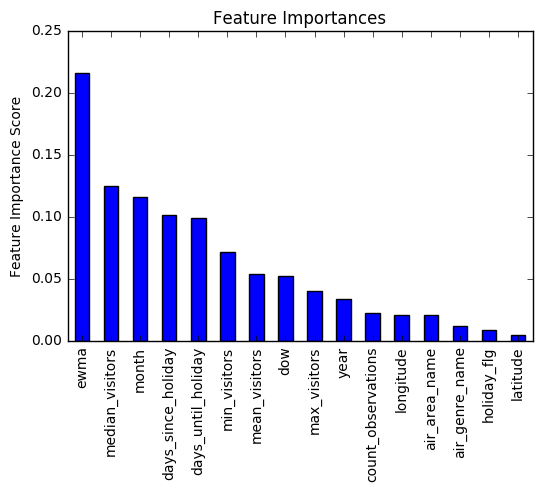

In [184]:
#Choose all predictors
predictors = columnsForTest_df
gbm0 = GradientBoostingRegressor(random_state=10)
modelfit(gbm0, x_train,y_train, predictors)